# MERGING GEOJSON

In [1]:
from os import listdir
from os.path import isfile, join

import re
from itertools import combinations
from itertools import chain

import pandas as pd
import numpy as np

import geopandas as gpd
import geojson
import rtree

import folium.folium

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import plugins

%matplotlib inline

pd.set_option('display.max_rows', 1000)

In [2]:
CLEAN_PATH = '../data/clean/transition' # transform this into temp file
SAVE_PATH = '../data/clean'

NAMES_DICT = {
    
    'cad_pa_gdf': 'CAD_PA',
    'o_build_gdf': 'O_CONS',
    'p_build_gdf': 'P_BU',
    'build_gdf': 'BU',
    'cad_zo_gdf': 'CAD_ZO',
    'mad_gdf': 'MAD'
}

In [3]:
all_raw_geofiles = [f for f in listdir(CLEAN_PATH) if isfile(join(CLEAN_PATH, f))]
all_raw_geofiles

['cadastralparcel.geojson',
 'otherconstruction.geojson',
 'buildingpart.geojson',
 'cadastralzoning.geojson',
 'building.geojson',
 '28900.geojson']

In [4]:
def changes_to_28900(gdf):
    return gdf.drop(['designator', 'yearOfConstruction'], axis = 1, inplace = True)

In [5]:
def merge_to_main_gdf(main_gdf, merged_gdf):
    """
    input:
    output: 
    """
    cols_to_keep_out = ['yearOfConstruction', 'label', 'geometry']     # this labels dont give any info
    cols_to_select = [col for col in merged_gdf.columns.tolist() if col not in cols_to_keep_out]
    
    if len(merged_gdf['ID'].unique()) == len(merged_gdf['ID'].array):
        return main_gdf.merge(merged_gdf[cols_to_select], on ='ID')

    else:
        aux_gdf = merged_gdf[cols_to_select].groupby(['ID']).max() # max as agg
        aux_gdf.reset_index(inplace = True)

        return main_gdf.merge(aux_gdf[cols_to_select], on = 'ID') # main_gdf.merge(aux_gdf, on ='ID')    

In [6]:
def split_xtr(x):
    if x:
        return x.split('_')[-1]

def height_to_floors(gdf):
    for col in gdf.columns:
        if len(re.findall(r'height\w+', col)) != 0:
            sec_part_name = re.split(r'height', col)[1]

            gdf[col] == gdf.apply(lambda x: x[col] / 3, axis = 1)
            gdf.rename(columns = {col: f'nFloors{sec_part_name}'}, inplace = True)
        
        elif len(re.findall(r'numberOf\w+', col)) != 0:
            sec_part_name = re.split(r'numberOf', col)[1]
            gdf.rename(columns = {col: f'n_{sec_part_name}'}, inplace = True)
            
        else: pass

In [7]:
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x|y') of edges/vertices of a Polygon/others"""

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.type=='MultiLineString':
        all_xy = []
        for ea in geometry:
            if coord_type == 'x':
                all_xy.append(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.xy[1] ))
        return all_xy

    if geometry.type=='MultiPolygon':
        all_xy = []
        for ea in geometry:
            if coord_type == 'x':
                all_xy.append(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []
    
def polygonToPtGeom(gdf):
    """
    from geom (poligons) -- > geom (points)
    """
    df_columns = [col for col in gdf.columns if col != 'geometry']
    
    # get coordinates in separate
    gdf['pX'] = gdf.apply(lambda x: float(x['pos'].split(" ")[0]), axis = 1)
    gdf['pY'] = gdf.apply(lambda x: float(x['pos'].split(" ")[1]), axis = 1)
    
    # get points for polygons
    gdf['polyX'] = gdf.apply(lambda x: getPolyCoords(x, 'geometry', 'x'), axis = 1)
    gdf['polyY'] = gdf.apply(lambda x: getPolyCoords(x, 'geometry', 'y'), axis = 1)
    
    # get points for polygons
    res_gdf = gpd.GeoDataFrame(gdf[df_columns],
                               geometry = gpd.points_from_xy(gdf['pX'], gdf['pY']))
    
    # geometry and polyX, polyY for polygons if needed
    return res_gdf

### LOADING BUILDING DATASET

In [8]:
build_gdf = gpd.read_file(f"{CLEAN_PATH}/building.geojson")
build_gdf.name = NAMES_DICT['build_gdf']

### LOADING BUILDING PART DATASET

In [9]:
# LOADING
p_build_gdf = gpd.read_file(f"{CLEAN_PATH}/buildingpart.geojson")
p_build_gdf.name = NAMES_DICT['p_build_gdf']

### LOADING CADASTRAL PARCEL DATASET

In [10]:
# LOADING
cad_pa_gdf = gpd.read_file(f"{CLEAN_PATH}/cadastralparcel.geojson")
cad_pa_gdf.name = NAMES_DICT['cad_pa_gdf']

### LOADING 28900 (MADRID) DATASET

In [11]:
# LOADING
mad_gdf = gpd.read_file(f"{CLEAN_PATH}/28900.geojson")
mad_gdf.name = NAMES_DICT['mad_gdf']

In [12]:
changes_to_28900(mad_gdf)

# Es un Dataset que muestra los portales de Madrid
# El ID es diferente al resto de DS
# Quizá habría que hacer un sjoin()

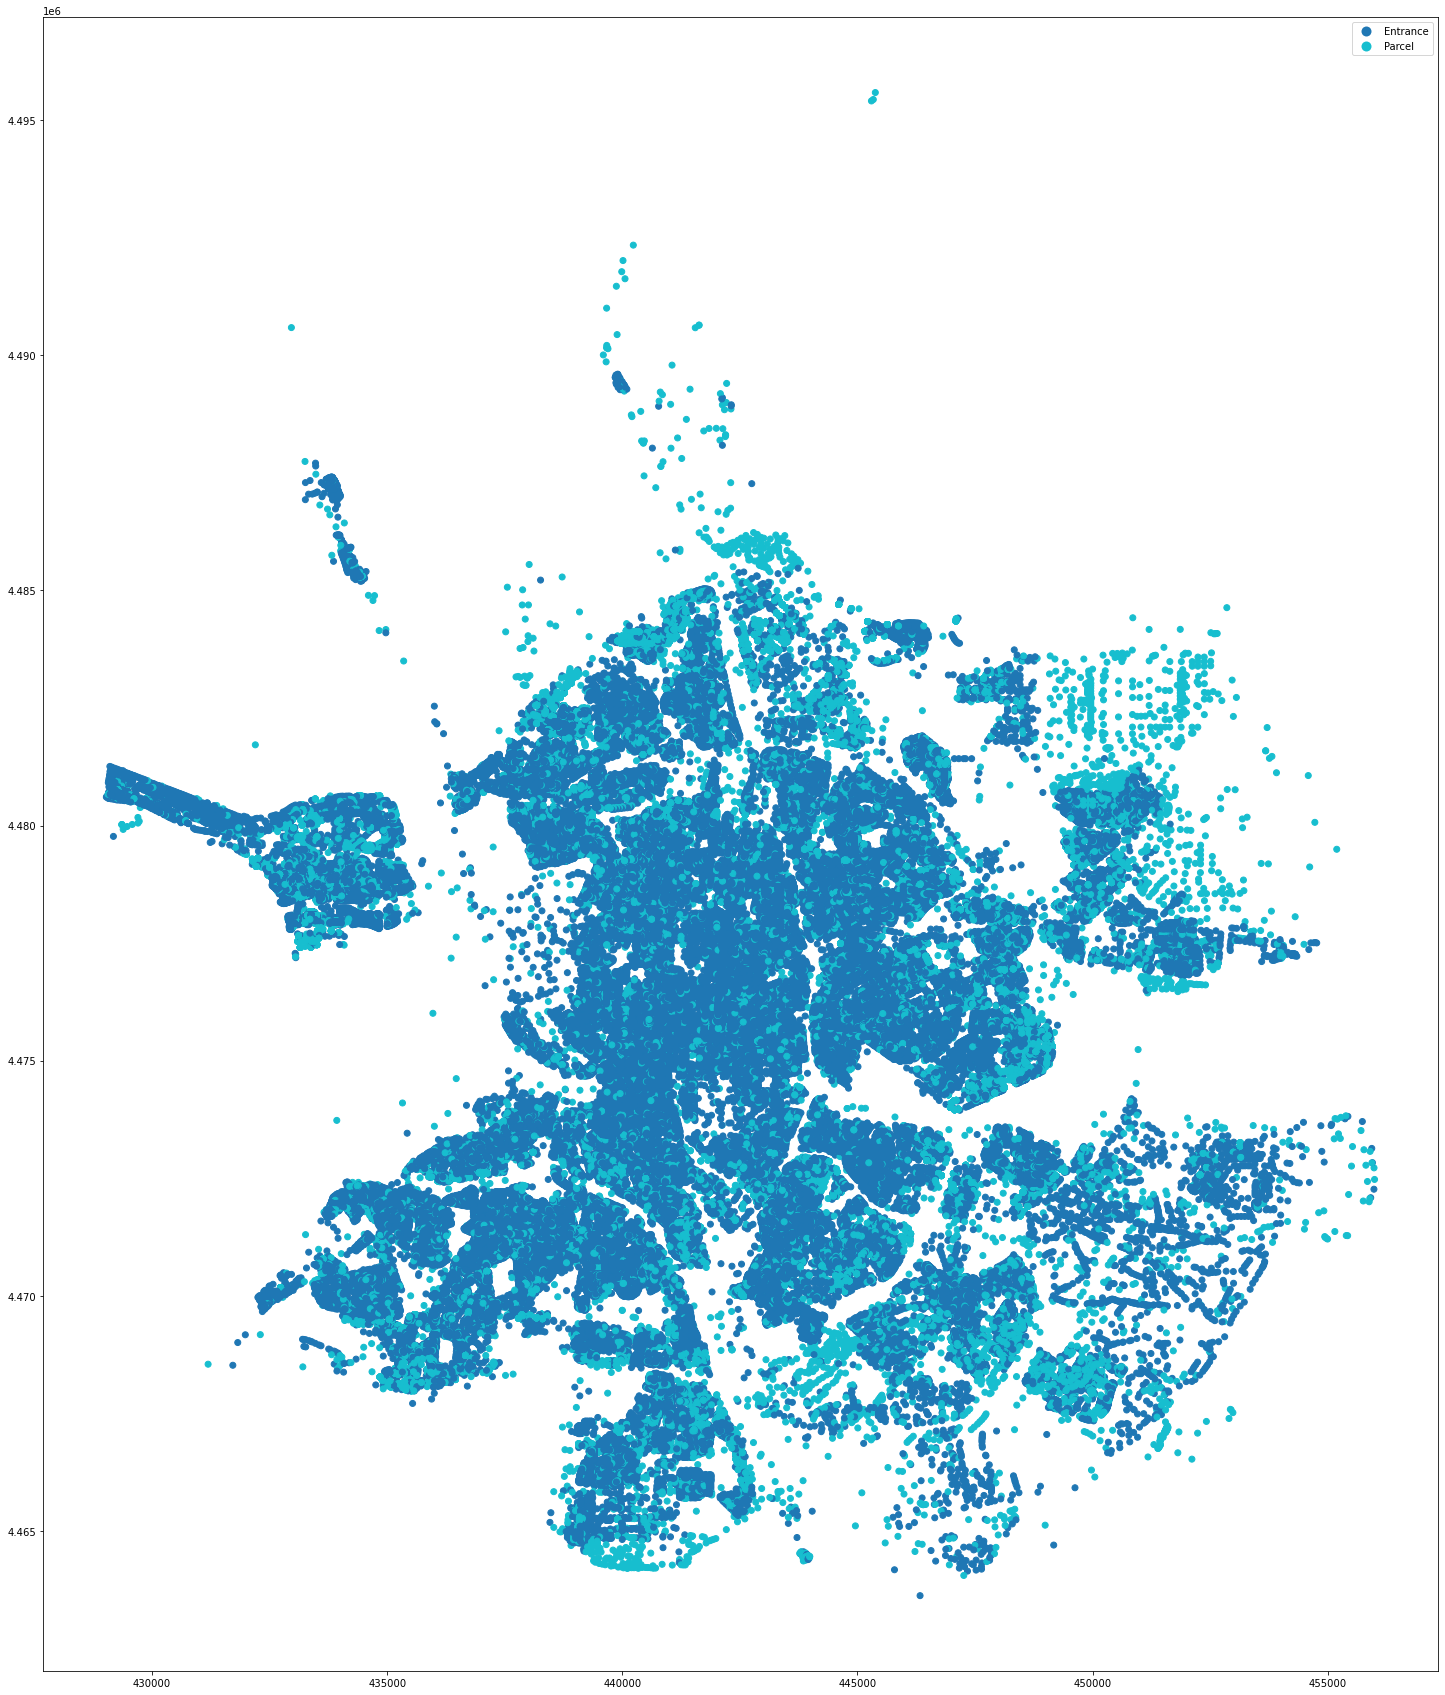

In [13]:
col_to_draw = 'specification' # col value corresponds grossfloorarea

mad_gdf[['geometry', col_to_draw]].plot(figsize = (25,35), column = col_to_draw, legend = True)
plt.show()

In [14]:
mad_gdf['specification'].value_counts()

Entrance    128039
Parcel       34345
Name: specification, dtype: int64

##  FINAL RESULT

In [15]:
# merging part_building to building-geojson
build_gdf = merge_to_main_gdf(main_gdf = build_gdf, 
                              merged_gdf = p_build_gdf)

In [16]:
# merging to building-geojson
final_gdf = merge_to_main_gdf(main_gdf = build_gdf, 
                              merged_gdf = cad_pa_gdf)

In [17]:
# tras los merge no es un geodataframe, luego hay que volverlo a convertir en uno
cols_to_select = [col for col in final_gdf.columns.tolist() if col not in list(re.findall(r"geometry", col))]
cols_to_select += ['geometry']

final_gdf = gpd.GeoDataFrame( final_gdf[cols_to_select], 
                              geometry = final_gdf['geometry'] )

# aplicando las funciones definidas
final_gdf['currentUse'] = final_gdf['currentUse'].apply(split_xtr) # limpiando currentUse
height_to_floors(final_gdf) # cambiando height --> floors 

# cambiando polygons por puntos
final_points_gdf = polygonToPtGeom(gdf = final_gdf)

# order of columns
order_cols = ['ID', 'conditionOfConstruction', 'currentUse', 'yearOfConstruction', 'n_BuildingUnits', 
              'n_Dwellings', 'nFloors_AG', 'nFloors_BG', 'ID_part', 'area_m2c', 'area_m2p', 'geometry']

final_points_gdf = final_points_gdf[order_cols]
final_polygs_gdf = final_gdf[order_cols]

# display 
display(final_points_gdf.head(2))
display(final_polygs_gdf.head(2))

display(type(final_points_gdf))
display(type(final_polygs_gdf))

display(final_points_gdf.shape)
display(final_polygs_gdf.shape)

,ID,conditionOfConstruction,currentUse,yearOfConstruction,n_BuildingUnits,n_Dwellings,nFloors_AG,nFloors_BG,ID_part,area_m2c,area_m2p,geometry
0,000200100VK48E,functional,agriculture,1968,1,0,1,0,1,26,26,POINT (441654.170 4487048.360)
1,000200500VK56E,declined,industrial,1995,1,0,1,0,2,646,1268,POINT (451607.030 4467199.270)


,ID,conditionOfConstruction,currentUse,yearOfConstruction,n_BuildingUnits,n_Dwellings,nFloors_AG,nFloors_BG,ID_part,area_m2c,area_m2p,geometry
0,000200100VK48E,functional,agriculture,1968,1,0,1,0,1,26,26,"POLYGON ((441657.574 4487050.292, 441658.164 4..."
1,000200500VK56E,declined,industrial,1995,1,0,1,0,2,646,1268,"MULTIPOLYGON (((451584.920 4467181.410, 451586..."


geopandas.geodataframe.GeoDataFrame

geopandas.geodataframe.GeoDataFrame

(122153, 12)

(122153, 12)

In [23]:
final_points_gdf['currentUse'].value_counts()

residential       108992
publicServices      3764
industrial          3603
retail              2753
office              2245
agriculture          301
Name: currentUse, dtype: int64

In [18]:
# 
# NOTE________________________________________________________________________________________
# This code is for merging portals gdf and build gdf... shape 20.7K Not good
# final_2_gdf = gpd.sjoin(mad_gdf, final_gdf, op='within', how = 'inner') # within or contains
#

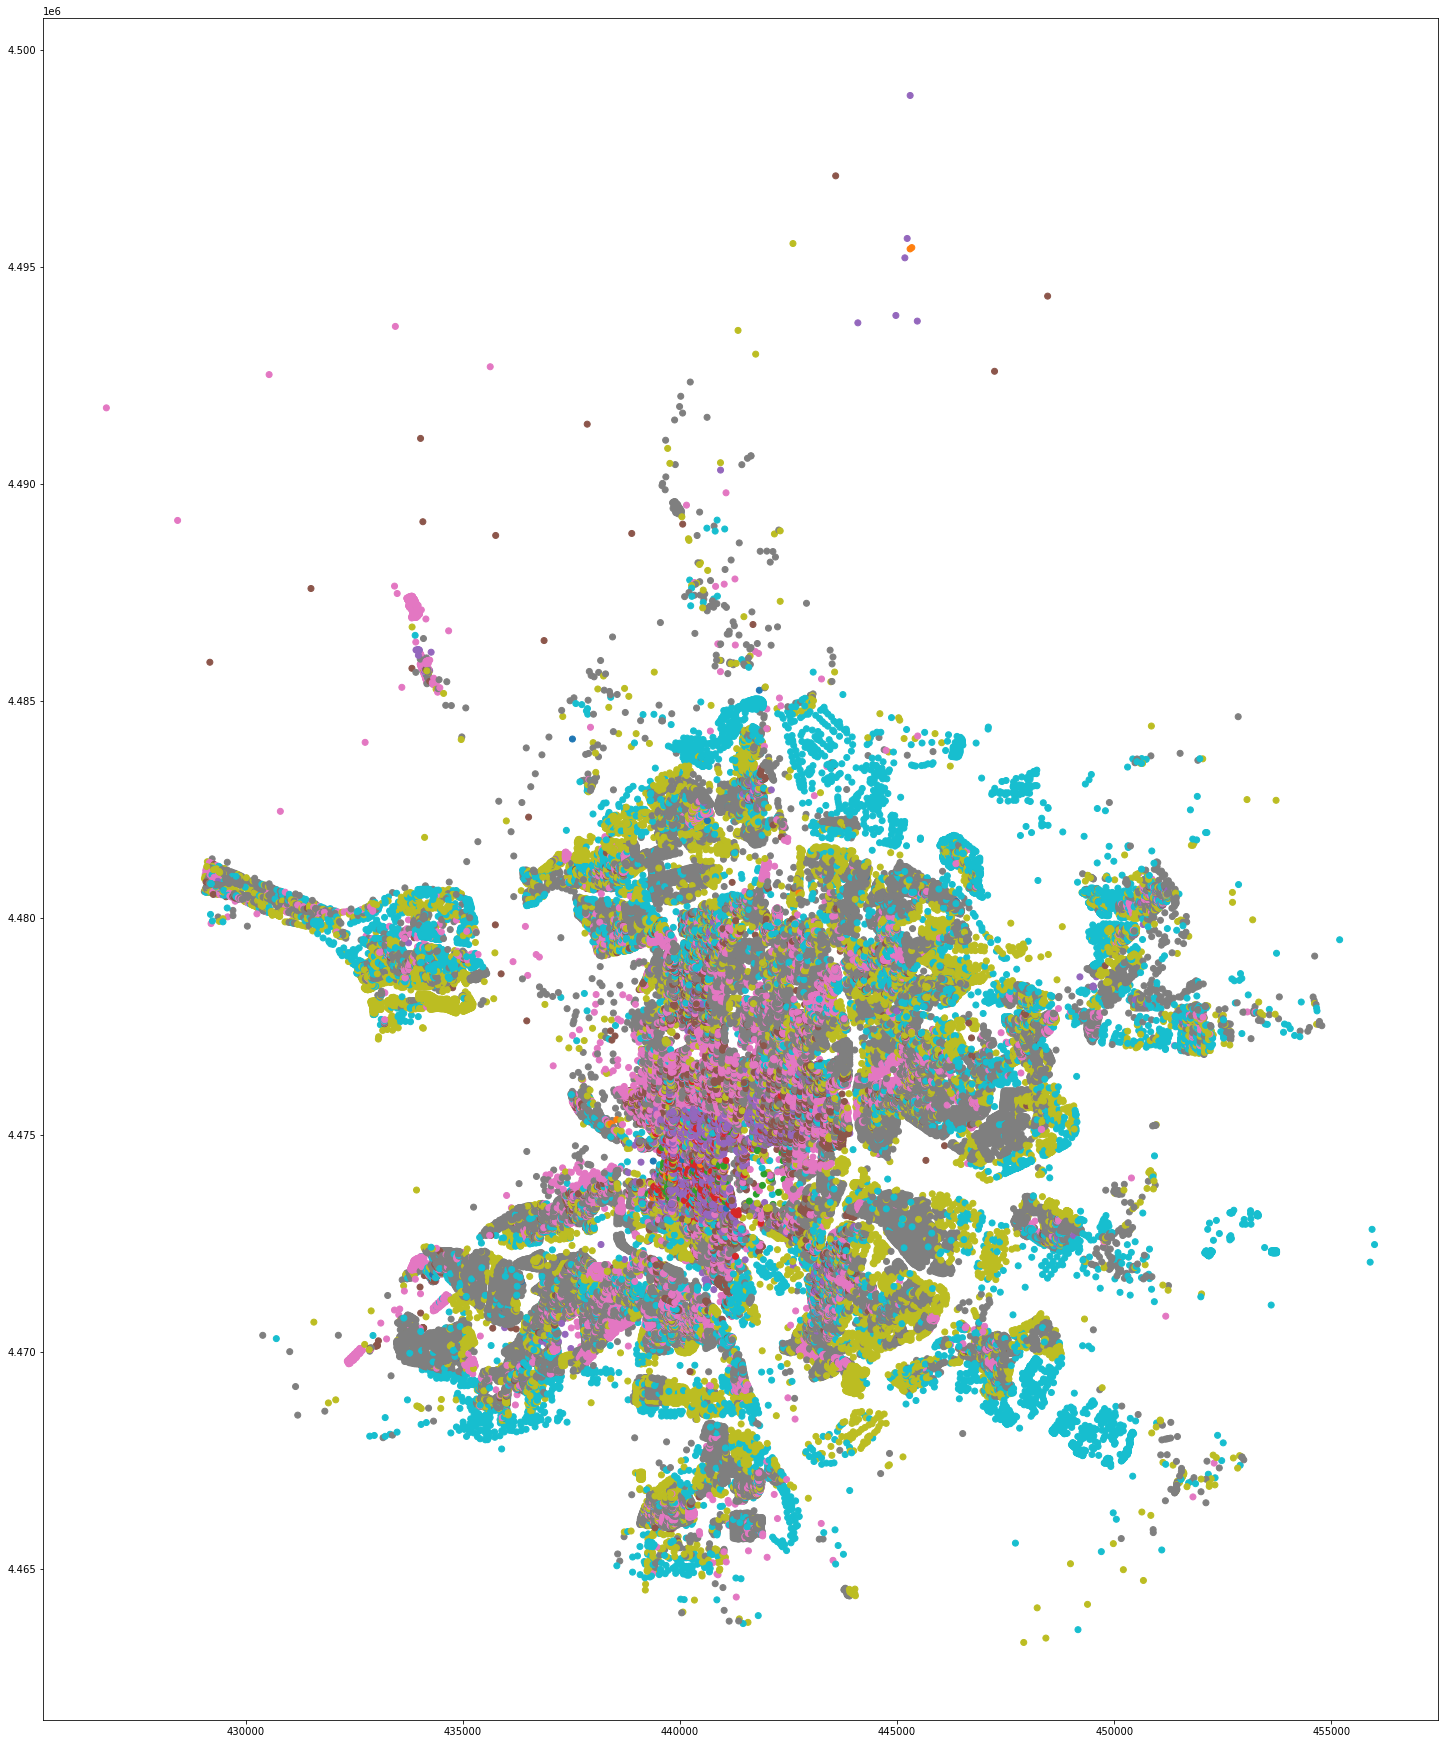

In [19]:
## drawing
col_to_draw = 'yearOfConstruction' # col value corresponds grossfloorarea

final_points_gdf[['geometry', col_to_draw]].plot(figsize = (25,35), column = col_to_draw, legend = False)
plt.show()

## SAVING FINAL FILES

In [24]:
final_polygs_gdf.to_file(f"{SAVE_PATH}/building_polygon.geojson", driver='GeoJSON')
final_points_gdf.to_file(f"{SAVE_PATH}/building_points.geojson", driver='GeoJSON')